# Data wrangling

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kagglehub import KaggleDatasetAdapter

## 1. Download disaster data from Kaggle

In [2]:
# Load a DataFrame with a specific version of a CSV
raw_data_df=kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    'headsortails/us-natural-disaster-declarations',
    'us_disaster_declarations.csv',
)

raw_data_df.head().transpose()

,0,1,2,3,4
fema_declaration_string,DR-1-GA,DR-2-TX,DR-3-LA,DR-4-MI,DR-5-MT
disaster_number,1,2,3,4,5
state,GA,TX,LA,MI,MT
declaration_type,DR,DR,DR,DR,DR
declaration_date,1953-05-02T00:00:00Z,1953-05-15T00:00:00Z,1953-05-29T00:00:00Z,1953-06-02T00:00:00Z,1953-06-06T00:00:00Z
fy_declared,1953,1953,1953,1953,1953
incident_type,Tornado,Tornado,Flood,Tornado,Flood
declaration_title,Tornado,Tornado & Heavy Rainfall,Flood,Tornado,Floods
ih_program_declared,0,0,0,0,0
ia_program_declared,1,1,1,1,1


In [3]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64092 entries, 0 to 64091
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   fema_declaration_string     64092 non-null  object
 1   disaster_number             64092 non-null  int64 
 2   state                       64092 non-null  object
 3   declaration_type            64092 non-null  object
 4   declaration_date            64092 non-null  object
 5   fy_declared                 64092 non-null  int64 
 6   incident_type               64092 non-null  object
 7   declaration_title           64092 non-null  object
 8   ih_program_declared         64092 non-null  int64 
 9   ia_program_declared         64092 non-null  int64 
 10  pa_program_declared         64092 non-null  int64 
 11  hm_program_declared         64092 non-null  int64 
 12  incident_begin_date         64092 non-null  object
 13  incident_end_date           55682 non-null  ob

In [4]:
raw_data_df.to_parquet('../data/raw_disaster_data.parquet')

## 2. Feature selection

In [5]:
# Get only the features we are going to work with into a new dataframe
working_df=raw_data_df[['incident_begin_date','state','incident_type']].copy()

# Convert 'incident_begin_date' to month and year columns and set as index
working_df['incident_begin_date']=pd.to_datetime(working_df['incident_begin_date'])

# Fix the index
working_df.reset_index(inplace=True, drop=True)
working_df.head()

,incident_begin_date,state,incident_type
0,1953-05-02 00:00:00+00:00,GA,Tornado
1,1953-05-15 00:00:00+00:00,TX,Tornado
2,1953-05-29 00:00:00+00:00,LA,Flood
3,1953-06-02 00:00:00+00:00,MI,Tornado
4,1953-06-06 00:00:00+00:00,MT,Flood


In [6]:
working_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64092 entries, 0 to 64091
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   incident_begin_date  64092 non-null  datetime64[ns, UTC]
 1   state                64092 non-null  object             
 2   incident_type        64092 non-null  object             
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 1.5+ MB


## 3. Incident encoding

In [7]:
# Define target disaster types for summation and prediction
target_disasters=['Severe Storm', 'Hurricane', 'Flood', 'Coastal Storm']

# Encode the disaster types to dummies
disaster_dummies_df=pd.get_dummies(working_df['incident_type'], dtype=int)

# Sum our target disasters
incidents=disaster_dummies_df[target_disasters].sum(axis=1)

# Add the disaster sums to the data frame as a new feature
working_df['incidents']=incidents

# Drop the string incident_type column
working_df.drop('incident_type', axis=1, inplace=True)

# Count how many disasters we have so that we can check later to make
# sure we didn't cause any issues in our data manipulations
starting_disaster_count=working_df['incidents'].sum()
starting_total_disaster_months=len(working_df[working_df['incidents'] != 0])
starting_percent_disaster_months=(starting_total_disaster_months/len(working_df)) * 100

print(f'Dataset is {len(working_df)} rows')
print(f'Have {starting_disaster_count} total incidents')
print(f'Have {starting_total_disaster_months}({starting_percent_disaster_months:.1f}%) dates with non-zero incident counts')

Dataset is 64092 rows
Have 41865 total incidents
Have 41865(65.3%) dates with non-zero incident counts


In [8]:
working_df.head()

,incident_begin_date,state,incidents
0,1953-05-02 00:00:00+00:00,GA,0
1,1953-05-15 00:00:00+00:00,TX,0
2,1953-05-29 00:00:00+00:00,LA,1
3,1953-06-02 00:00:00+00:00,MI,0
4,1953-06-06 00:00:00+00:00,MT,1


Now, we need to regularize the time series to a frequency of months across the span of years within each state.

## 4. Time series regularization

In [9]:
def sum_months(group: pd.DataFrame) -> pd.DataFrame:
    '''Takes a yearly groupby object and sums features over months'''

    return group.resample('ME').sum()


def resample_months(group: pd.DataFrame) -> pd.DataFrame:
    '''Takes working dataframe and resamples frequency to months.
    Returns updated dataframe'''

    # Set 'incident_begin_date' as datetime axis
    group=group.set_index('incident_begin_date')

    # Sum the disasters in each month by year. This removes duplicates where
    # there was more than one disaster in a month.
    group=group.groupby(group.index.year, group_keys=False).apply(sum_months)

    # Resample to monthly frequency
    group=group.resample('ME').asfreq()

    # Fill missing values with 0
    group=group.fillna(0)

    # Convert everything to int
    group=group.astype(int)

    # Reset the index, preserving the `incident_begin_date`
    group.reset_index(inplace=True, drop=False)

    return group

# Do the resampling
resampled_working_df=working_df.groupby('state', group_keys=True).apply(resample_months, include_groups=False)

# Unset the group index
resampled_working_df.reset_index(inplace=True, drop=False)
resampled_working_df.drop('level_1', axis=1, inplace=True)

# Re-check disaster counts
disaster_count=resampled_working_df['incidents'].sum()
total_disaster_months=len(resampled_working_df[resampled_working_df['incidents'] != 0])
percent_disaster_months=(total_disaster_months/len(resampled_working_df)) * 100

print(f'Dataset is {len(resampled_working_df)} rows')
print(f'\nHave {disaster_count} total incidents')
print(f'Have {total_disaster_months}({percent_disaster_months:.1f}%) months with non-zero incident counts')

Dataset is 43639 rows

Have 41865 total incidents
Have 2138(4.9%) months with non-zero incident counts


In [10]:
resampled_working_df.head()

,state,incident_begin_date,incidents
0,AK,1953-10-31 00:00:00+00:00,0
1,AK,1953-11-30 00:00:00+00:00,0
2,AK,1953-12-31 00:00:00+00:00,0
3,AK,1954-01-31 00:00:00+00:00,0
4,AK,1954-02-28 00:00:00+00:00,0


In [11]:
resampled_working_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43639 entries, 0 to 43638
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   state                43639 non-null  object             
 1   incident_begin_date  43639 non-null  datetime64[ns, UTC]
 2   incidents            43639 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 1022.9+ KB


## 3. Time features encoding

In [12]:
# Extract month and year from 'incident_begin_date' and drop
resampled_working_df['year']=resampled_working_df['incident_begin_date'].dt.year.astype(int)
resampled_working_df['month']=resampled_working_df['incident_begin_date'].dt.month.astype(int)
resampled_working_df.drop('incident_begin_date', axis=1, inplace=True)

In [13]:
# Encode month with sin and cos components
resampled_working_df['month_sin'] = np.sin(2 * np.pi * resampled_working_df['month']/12.0)
resampled_working_df['month_cos'] = np.cos(2 * np.pi * resampled_working_df['month']/12.0)

In [14]:
resampled_working_df.head()

,state,incidents,year,month,month_sin,month_cos
0,AK,0,1953,10,-8.660254e-01,0.500000
1,AK,0,1953,11,-5.000000e-01,0.866025
2,AK,0,1953,12,-2.449294e-16,1.000000
3,AK,0,1954,1,5.000000e-01,0.866025
4,AK,0,1954,2,8.660254e-01,0.500000


## 4. Encode state

In [15]:
# Dummy encode state
states=pd.get_dummies(resampled_working_df['state'], dtype=int, drop_first=True)

# Add the state dummies to the dataframe
resampled_working_df=pd.concat([resampled_working_df, states], axis=1)

In [16]:
resampled_working_df.head()

,state,incidents,year,month,month_sin,month_cos,AL,AR,AS,AZ,...,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
0,AK,0,1953,10,-8.660254e-01,0.500000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AK,0,1953,11,-5.000000e-01,0.866025,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AK,0,1953,12,-2.449294e-16,1.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AK,0,1954,1,5.000000e-01,0.866025,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AK,0,1954,2,8.660254e-01,0.500000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 5. Set index

In [17]:
# Create multiindex
indexes=[
    resampled_working_df['year'].tolist(),
    resampled_working_df['state'].tolist(),
    resampled_working_df['month'].tolist()
]

index_tuples=list(zip(*indexes))
index=pd.MultiIndex.from_tuples(index_tuples, names=['year', 'state', 'month'])
resampled_working_df.set_index(index, inplace=True)

In [18]:
resampled_working_df.head()

state  incidents  year  month     month_sin  month_cos  AL  \
year state month                                                              
1953 AK    10       AK          0  1953     10 -8.660254e-01   0.500000   0   
           11       AK          0  1953     11 -5.000000e-01   0.866025   0   
           12       AK          0  1953     12 -2.449294e-16   1.000000   0   
1954 AK    1        AK          0  1954      1  5.000000e-01   0.866025   0   
           2        AK          0  1954      2  8.660254e-01   0.500000   0   

                  AR  AS  AZ  ...  TN  TX  UT  VA  VI  VT  WA  WI  WV  WY  
year state month              ...                                          
1953 AK    10      0   0   0  ...   0   0   0   0   0   0   0   0   0   0  
           11      0   0   0  ...   0   0   0   0   0   0   0   0   0   0  
           12      0   0   0  ...   0   0   0   0   0   0   0   0   0   0  
1954 AK    1       0   0   0  ...   0   0   0   0   0   0   0   0   0   0  
           2       0   0   0  ...   0   0   0   0   0   0   0   0   0   0  

[5 rows x 64 columns]

## 7. Clip and transform data

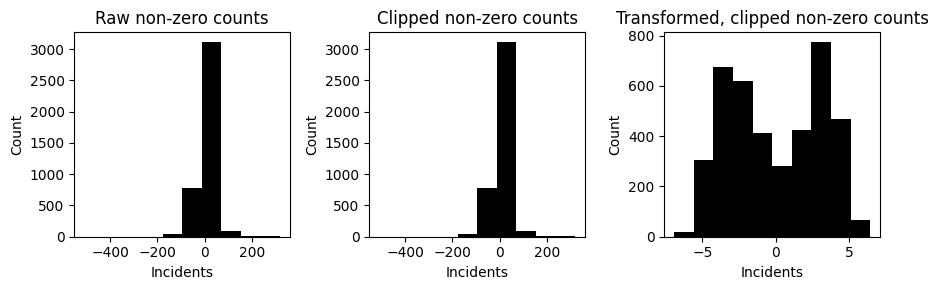

In [19]:
# Detrend incidents
resampled_working_df['detrended_incidents']=resampled_working_df['incidents'].diff(periods=1)

# Get the raw incident counts
original_incident_counts=np.array(resampled_working_df['detrended_incidents'])

# Trim them to +/- 3 sigma
mean=original_incident_counts.mean()
stddev=original_incident_counts.std()
clipped_incident_counts=np.array(resampled_working_df['detrended_incidents'].clip(lower=mean - 3*stddev, upper=mean + 3*stddev))

# Transform them with inverse hyperbolic tangent
transformed_clipped_incident_counts=np.arcsinh(clipped_incident_counts)

# Add as new feature
resampled_working_df['transformed_detrended_incidents']=transformed_clipped_incident_counts

fig, axs=plt.subplots(1,3, figsize=(9,3))

axs[0].set_title('Raw non-zero counts')
axs[0].hist(original_incident_counts[original_incident_counts != 0], bins=10, color='black')
axs[0].set_xlabel('Incidents')
axs[0].set_ylabel('Count')

axs[1].set_title('Clipped non-zero counts')
axs[1].hist(clipped_incident_counts[clipped_incident_counts != 0], bins=10, color='black')
axs[1].set_xlabel('Incidents')
axs[1].set_ylabel('Count')

axs[2].set_title('Transformed, clipped non-zero counts')
axs[2].hist(transformed_clipped_incident_counts[transformed_clipped_incident_counts != 0], bins=10, color='black')
axs[2].set_xlabel('Incidents')
axs[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [20]:
resampled_working_df.drop(['year', 'month', 'state'], axis=1, inplace=True)
year_means=resampled_working_df.groupby('year').mean()
year_means.head()

,incidents,month_sin,month_cos,AL,AR,AS,AZ,CA,CO,CT,...,UT,VA,VI,VT,WA,WI,WV,WY,detrended_incidents,transformed_detrended_incidents
year,,,,,,,,,,,,,,,,,,,,,
1953,0.076923,-0.478284,0.063600,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,-1.734375,-0.287581
1954,0.074866,-0.134355,0.117263,0.0,0.000000,0.0,0.0,0.058824,0.000000,0.021390,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.026738,0.0,-0.796791,-0.113153
1955,0.047022,-0.059644,0.005122,0.0,0.000000,0.0,0.0,0.037618,0.025078,0.037618,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.037618,0.0,-0.141066,-0.019591
1956,0.030534,-0.023741,-0.003135,0.0,0.000000,0.0,0.0,0.030534,0.030534,0.030534,...,0.0,0.000000,0.0,0.0,0.027990,0.0,0.030534,0.0,-0.124682,-0.038127
1957,0.025641,-0.038804,-0.005551,0.0,0.017094,0.0,0.0,0.025641,0.025641,0.025641,...,0.0,0.023504,0.0,0.0,0.025641,0.0,0.025641,0.0,-0.352564,-0.034329


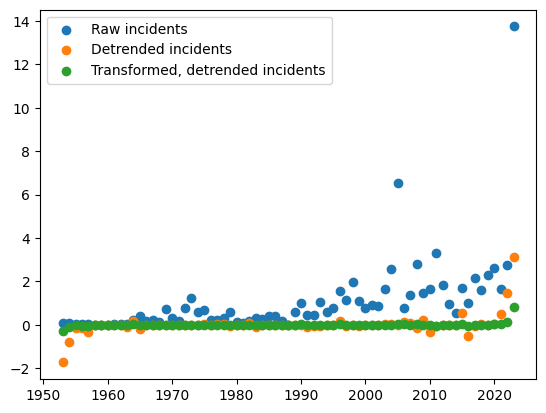

In [21]:
plt.scatter(year_means.index, year_means['incidents'], label='Raw incidents')
plt.scatter(year_means.index, year_means['detrended_incidents'], label='Detrended incidents')
plt.scatter(year_means.index, year_means['transformed_detrended_incidents'], label='Transformed, detrended incidents')
plt.legend(loc='upper left')
plt.show()

In [22]:
year_means.tail()

,incidents,month_sin,month_cos,AL,AR,AS,AZ,CA,CO,CT,...,UT,VA,VI,VT,WA,WI,WV,WY,detrended_incidents,transformed_detrended_incidents
year,,,,,,,,,,,,,,,,,,,,,
2019,2.303571,-3.405469e-20,-3.700743e-17,0.017857,0.017857,0.017857,0.017857,0.017857,0.017857,0.017857,...,0.017857,0.017857,0.017857,0.017857,0.017857,0.017857,0.017857,0.017857,-0.028274,-0.007952
2020,2.621311,1.021648e-02,-6.588915e-04,0.019672,0.019672,0.019672,0.019672,0.019672,0.019672,0.019672,...,0.019672,0.019672,0.019672,0.019672,0.019672,0.001639,0.019672,0.014754,0.039344,0.018933
2021,1.658802,2.618549e-02,-2.600749e-02,0.021779,0.021779,0.021779,0.021779,0.021779,0.021779,0.016334,...,0.014519,0.021779,0.021779,0.021779,0.021779,0.000000,0.021779,0.000000,0.486388,0.060316
2022,2.749216,1.687987e-01,-1.062455e-01,0.037618,0.000000,0.021944,0.031348,0.037618,0.000000,0.000000,...,0.000000,0.021944,0.021944,0.037618,0.034483,0.000000,0.025078,0.000000,1.457680,0.128081
2023,13.750000,7.165064e-01,5.580127e-01,0.125000,0.000000,0.000000,0.000000,0.375000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.125000,0.809612


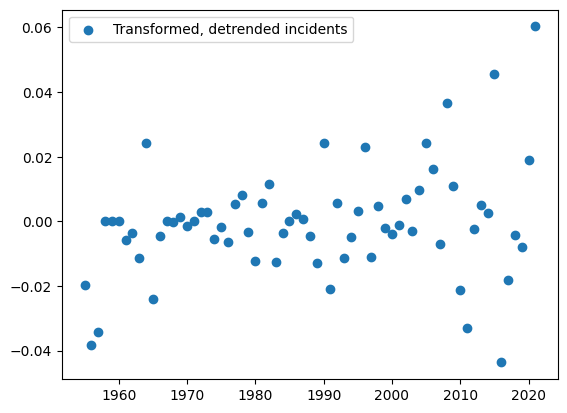

In [23]:
# Drop the first and last two years
year_means=year_means.iloc[2:-2,:]
plt.scatter(year_means.index, year_means['transformed_detrended_incidents'], label='Transformed, detrended incidents')
plt.legend(loc='upper left')
plt.show()

This needs some clean-up, but I think we are onto something. Let's try it!

In [24]:
resampled_working_df=resampled_working_df.loc[resampled_working_df.index.get_level_values('year') > 1954]
resampled_working_df=resampled_working_df.loc[resampled_working_df.index.get_level_values('year') < 2020]

In [25]:
resampled_working_df.head()

incidents  month_sin     month_cos  AL  AR  AS  AZ  CA  CO  \
year state month                                                               
1955 AK    1              0   0.500000  8.660254e-01   0   0   0   0   0   0   
           2              0   0.866025  5.000000e-01   0   0   0   0   0   0   
           3              0   1.000000  6.123234e-17   0   0   0   0   0   0   
           4              0   0.866025 -5.000000e-01   0   0   0   0   0   0   
           5              0   0.500000 -8.660254e-01   0   0   0   0   0   0   

                  CT  ...  UT  VA  VI  VT  WA  WI  WV  WY  \
year state month      ...                                   
1955 AK    1       0  ...   0   0   0   0   0   0   0   0   
           2       0  ...   0   0   0   0   0   0   0   0   
           3       0  ...   0   0   0   0   0   0   0   0   
           4       0  ...   0   0   0   0   0   0   0   0   
           5       0  ...   0   0   0   0   0   0   0   0   

                  detrended_incidents  transformed_detrended_incidents  
year state month                                                        
1955 AK    1                      0.0                              0.0  
           2                      0.0                              0.0  
           3                      0.0                              0.0  
           4                      0.0                              0.0  
           5                      0.0                              0.0  

[5 rows x 63 columns]

## 9. Clean up columns

In [26]:
# Create binary incident column for labels
resampled_working_df['incidents_binary']=resampled_working_df['incidents'].clip(lower=0, upper=1)
resampled_working_df['incidents']=resampled_working_df['transformed_detrended_incidents']
resampled_working_df.drop(['detrended_incidents', 'transformed_detrended_incidents'], axis=1, inplace=True)
resampled_working_df.head(20)

incidents     month_sin     month_cos  AL  AR  AS  AZ  CA  \
year state month                                                              
1955 AK    1            0.0  5.000000e-01  8.660254e-01   0   0   0   0   0   
           2            0.0  8.660254e-01  5.000000e-01   0   0   0   0   0   
           3            0.0  1.000000e+00  6.123234e-17   0   0   0   0   0   
           4            0.0  8.660254e-01 -5.000000e-01   0   0   0   0   0   
           5            0.0  5.000000e-01 -8.660254e-01   0   0   0   0   0   
           6            0.0  1.224647e-16 -1.000000e+00   0   0   0   0   0   
           7            0.0 -5.000000e-01 -8.660254e-01   0   0   0   0   0   
           8            0.0 -8.660254e-01 -5.000000e-01   0   0   0   0   0   
           9            0.0 -1.000000e+00 -1.836970e-16   0   0   0   0   0   
           10           0.0 -8.660254e-01  5.000000e-01   0   0   0   0   0   
           11           0.0 -5.000000e-01  8.660254e-01   0   0   0   0   0   
           12           0.0 -2.449294e-16  1.000000e+00   0   0   0   0   0   
1956 AK    1            0.0  5.000000e-01  8.660254e-01   0   0   0   0   0   
           2            0.0  8.660254e-01  5.000000e-01   0   0   0   0   0   
           3            0.0  1.000000e+00  6.123234e-17   0   0   0   0   0   
           4            0.0  8.660254e-01 -5.000000e-01   0   0   0   0   0   
           5            0.0  5.000000e-01 -8.660254e-01   0   0   0   0   0   
           6            0.0  1.224647e-16 -1.000000e+00   0   0   0   0   0   
           7            0.0 -5.000000e-01 -8.660254e-01   0   0   0   0   0   
           8            0.0 -8.660254e-01 -5.000000e-01   0   0   0   0   0   

                  CO  CT  ...  TX  UT  VA  VI  VT  WA  WI  WV  WY  \
year state month          ...                                       
1955 AK    1       0   0  ...   0   0   0   0   0   0   0   0   0   
           2       0   0  ...   0   0   0   0   0   0   0   0   0   
           3       0   0  ...   0   0   0   0   0   0   0   0   0   
           4       0   0  ...   0   0   0   0   0   0   0   0   0   
           5       0   0  ...   0   0   0   0   0   0   0   0   0   
           6       0   0  ...   0   0   0   0   0   0   0   0   0   
           7       0   0  ...   0   0   0   0   0   0   0   0   0   
           8       0   0  ...   0   0   0   0   0   0   0   0   0   
           9       0   0  ...   0   0   0   0   0   0   0   0   0   
           10      0   0  ...   0   0   0   0   0   0   0   0   0   
           11      0   0  ...   0   0   0   0   0   0   0   0   0   
           12      0   0  ...   0   0   0   0   0   0   0   0   0   
1956 AK    1       0   0  ...   0   0   0   0   0   0   0   0   0   
           2       0   0  ...   0   0   0   0   0   0   0   0   0   
           3       0   0  ...   0   0   0   0   0   0   0   0   0   
           4       0   0  ...   0   0   0   0   0   0   0   0   0   
           5       0   0  ...   0   0   0   0   0   0   0   0   0   
           6       0   0  ...   0   0   0   0   0   0   0   0   0   
           7       0   0  ...   0   0   0   0   0   0   0   0   0   
           8       0   0  ...   0   0   0   0   0   0   0   0   0   

                  incidents_binary  
year state month                    
1955 AK    1                     0  
           2                     0  
           3                     0  
           4                     0  
           5                     0  
           6                     0  
           7                     0  
           8                     0  
           9                     0  
           10                    0  
           11                    0  
           12                    0  
1956 AK    1                     0  
           2                     0  
           3                     0  
           4                     0  
           5                     0  
           6                     0  
           7        

## 10. Save

In [27]:
# Save the complete dataset
resampled_working_df.to_parquet('../data/resampled_disaster_data_all.parquet')